# Random Forest Model : Classifier

The Random Forest algorithm is an ensemble learning method used for classification and regression tasks. It builds multiple decision trees during training and merges their predictions to provide a more accurate and robust result. Each tree in the forest is trained on a random subset of the data, and the final prediction is determined by a majority vote or average of individual tree predictions. Random Forests are effective in reducing overfitting, handling large datasets, and capturing complex relationships in the data. They are widely used in various applications, including finance and trading, due to their versatility and ability to handle diverse datasets.

In [1]:
# Importing necessary library
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Download data
df = yf.download("TCS",start ='2013-12-31',end ='2023-12-30')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,46.290001,47.070000,45.599998,46.610001,43.570217,460800
2014-01-02,46.869999,46.869999,43.779999,43.779999,40.924782,798800
2014-01-03,44.790001,45.180000,41.779999,42.660000,39.877827,1247300
2014-01-06,44.669998,45.000000,42.759998,42.980000,40.176956,1101300
2014-01-07,43.840000,45.790001,43.119999,45.790001,42.803696,1677300
...,...,...,...,...,...,...
2023-12-22,2.340000,2.450000,2.300000,2.320000,2.320000,243400
2023-12-26,2.330000,2.520000,2.310000,2.470000,2.470000,286600
2023-12-27,2.430000,2.440000,2.330000,2.340000,2.340000,412000


In [3]:
# Make the copy of the data. We will work on the copied data.
data = df.copy()

In [4]:
# Inspect the data
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-12-31,46.290001,47.070000,45.599998,46.610001,43.570217,460800
2014-01-02,46.869999,46.869999,43.779999,43.779999,40.924782,798800
2014-01-03,44.790001,45.180000,41.779999,42.660000,39.877827,1247300
2014-01-06,44.669998,45.000000,42.759998,42.980000,40.176956,1101300
2014-01-07,43.840000,45.790001,43.119999,45.790001,42.803696,1677300


In [5]:
# Generate log returns
data['returns'] = np.log(data['Close'] / data['Close'].shift(1))

In [6]:
# Create target values
data['target'] = np.where(data['returns'].shift(-1) > 0, 1, 0)

In [7]:
# Creating features
features_list = []

# SD based features
for i in range(5, 20, 5):
    col_name = 'std_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).std()
    features_list.append(col_name)
    
# MA based features
for i in range(10, 30, 5):
    col_name = 'ma_' + str(i)
    data[col_name] = data['Close'].rolling(window=i).mean()
    features_list.append(col_name)
    
# Daily pct change based features
for i in range(3, 12, 3):
    col_name = 'pct_' + str(i)
    data[col_name] = data['Close'].pct_change().rolling(i).sum()
    features_list.append(col_name)

# Intraday movement
col_name = 'co'
data[col_name] = data['Close'] - data['Open']
features_list.append(col_name)

In [8]:
# Volume Rate of Change
for i in [5, 10, 15]:
    col_name = f'Volume_ROC_{i}'
    data[col_name] = data['Volume'].pct_change()
    features_list.append(col_name)

#  Relative Strength Index (RSI)
for i in [14, 21, 30]:
    col_name = f'RSI_{i}'
    delta = data['Close'].diff(1)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=i, min_periods=1).mean()
    avg_loss = loss.rolling(window=i, min_periods=1).mean()
    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    data[col_name] = rsi
    features_list.append(col_name)


#  Average True Range (ATR)
for i in [14, 20]:
    col_name = f'ATR_{i}'
    high_low = data['High'] - data['Low']
    high_close = abs(data['High'] - data['Close'].shift(1))
    low_close = abs(data['Low'] - data['Close'].shift(1))
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = tr.rolling(window=i).mean()
    data[col_name] = atr
    features_list.append(col_name)

# Display the updated data with new features
data[features_list + ['target']].head()


,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,co,Volume_ROC_5,Volume_ROC_10,Volume_ROC_15,RSI_14,RSI_21,RSI_30,ATR_14,ATR_20,target
Date,,,,,,,,,,,,,,,,,,,,
2013-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.320000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2014-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.090000,0.733507,0.733507,0.733507,0.000000,0.000000,0.000000,NaN,NaN,0
2014-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.130001,0.561467,0.561467,0.561467,0.000000,0.000000,0.000000,NaN,NaN,1
2014-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.078798,NaN,NaN,-1.689999,-0.117053,-0.117053,-0.117053,7.494137,7.494137,7.494137,NaN,NaN,1
2014-01-07,1.749152,NaN,NaN,NaN,NaN,NaN,NaN,0.047298,NaN,NaN,1.950001,0.523018,0.523018,0.523018,44.209043,44.209043,44.209043,NaN,NaN,0


In [9]:
# Removing nan values
data.dropna(inplace=True)

In [10]:
data[features_list + ['target']].head()

,std_5,std_10,std_15,ma_10,ma_15,ma_20,ma_25,pct_3,pct_6,pct_9,co,Volume_ROC_5,Volume_ROC_10,Volume_ROC_15,RSI_14,RSI_21,RSI_30,ATR_14,ATR_20,target
Date,,,,,,,,,,,,,,,,,,,,
2014-02-05,0.471413,0.887259,1.201753,36.785,37.426667,37.7615,39.0820,-0.026659,-0.018415,-0.058386,-0.690002,-0.230505,-0.230505,-0.230505,26.363618,33.620693,29.380466,1.519287,1.966001,1
2014-02-06,0.520125,0.787031,1.072640,36.688,37.268667,37.6625,38.6988,0.025455,0.045601,-0.021555,1.259998,-0.004188,-0.004188,-0.004188,38.915087,28.634149,32.632345,1.521429,1.709501,1
2014-02-07,1.024085,0.879384,1.025509,36.735,37.236000,37.6785,38.4844,0.046113,0.044492,0.021515,1.279999,0.697785,0.697785,0.697785,50.214117,48.047651,35.864688,1.529286,1.597501,0
2014-02-10,1.089711,0.943898,1.010767,36.779,37.222667,37.6150,38.3052,0.066805,0.040146,0.048390,-0.419998,-0.487781,-0.487781,-0.487781,48.688352,50.277015,35.570013,1.556429,1.579000,1
2014-02-11,1.328861,1.194853,1.086459,37.045,37.270667,37.6180,38.1520,0.056696,0.082151,0.102297,0.600002,0.376209,0.376209,0.376209,53.428577,48.933146,37.640827,1.619286,1.564001,0


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score , recall_score, confusion_matrix

In [12]:
#Splitting data into train and test
X_train , X_test, y_train, y_test = train_test_split(data[features_list].iloc[:-1],
                                                    data.iloc[:-1]['target'],
                                                    test_size= 0.25, 
                                                    shuffle=False)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1869, 19), (1869,), (623, 19), (623,))

In [13]:
# From required libraries
from sklearn.ensemble import RandomForestClassifier

In [14]:
RandomForestClassifier?

In [15]:
# Define a model
model = RandomForestClassifier(n_estimators=20, 
                               max_depth=3,
                               max_leaf_nodes=5, 
                               random_state=1, 
                               max_features=5, 
                               min_samples_leaf=1)
# n_estimators=20 means it will build 20 diffrent trees

# Train the model
model.fit(X_train, y_train)
# Predict on a train dataset
y_pred_train = model.predict(X_train)

In [16]:
print('Model accuracy on training data:', model.score(X_train, y_train))

Model accuracy on training data: 0.5719636169074371


In [17]:
# Predict on a test dataset
y_pred = model.predict(X_test)

In [18]:
print('Model accuracy on testing data:', model.score(X_test, y_test))

Model accuracy on testing data: 0.5184590690208668


In [19]:
print('Accuracy score of model is :', accuracy_score(y_test, y_pred))
print('Precision score is :',precision_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('Recall vlaue is :', recall_score(y_test, y_pred))
print('*************Classification Report **************')
print(classification_report(y_test, y_pred))

Accuracy score of model is : 0.5184590690208668
Precision score is : 0.4642857142857143
[[271  60]
 [240  52]]
Recall vlaue is : 0.1780821917808219
*************Classification Report **************
              precision    recall  f1-score   support

           0       0.53      0.82      0.64       331
           1       0.46      0.18      0.26       292

    accuracy                           0.52       623
   macro avg       0.50      0.50      0.45       623
weighted avg       0.50      0.52      0.46       623



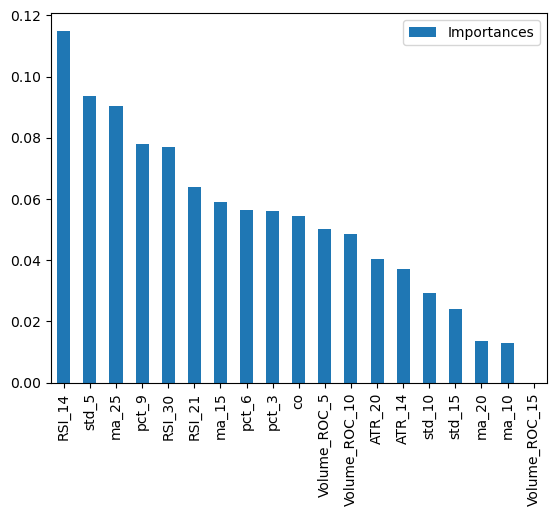

In [20]:
imp_features = model.feature_importances_

plot_df = pd.DataFrame({"Importances": imp_features}, index=features_list)
plot_df.sort_values('Importances', ascending=False).plot.bar();